In [1]:
from bs4 import BeautifulSoup # 分析html文件用
import requests # 連線用
import pandas as pd # 存成表格用
import re # regular expression
import jieba # 中文斷詞
from wordcloud import WordCloud # 文字雲用
from collections import Counter # 計數量用
import matplotlib.pyplot as plt # 畫圖(文字雲)用
import time # sleep用

In [2]:
jieba.set_dictionary('dict.txt.big') # 用繁體字庫
jieba.load_userdict('userDict.txt') # 增加自訂義字庫

Building prefix dict from C:\Users\rzdxcrow\Documents\GitHub\2nd-PyCrawlerMarathon\homework\dict.txt.big ...
Loading model from cache C:\Users\rzdxcrow\AppData\Local\Temp\jieba.u3c449fc0ff395bc676b53845bdb323e4.cache
Loading model cost 1.363 seconds.
Prefix dict has been built successfully.


In [3]:
def remove_stop_words(file_name,seg_list): # 去除stop word
    with open(file_name,'r',encoding='utf-8-sig') as f: #從檔案load stop word
        stop_words = f.readlines() 
    stop_words.append('\n') #去除空行
    stop_words.append('\n\n') #去除空行
    stop_words.append(':') #去除冒號
    stop_words.append(' ') #去除空白
    new_list = []

    for seg in seg_list:
        if seg not in stop_words: # 不在stop word的word放到new_list裡，其餘丟棄
            new_list.append(seg)
    return new_list

In [4]:
home_url='https://www.ptt.cc/bbs/HatePolitics/index.html' # 政黑板url
url_pre='https://www.ptt.cc'
stopwordfile='stopword.txt'


re_ip=r'(來自:) ((([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])) ' #發文的IP的regex
re_remove_arti=r'※ 文章網址' #需移除的regex
re_remove_edit=r'※ 編輯' #需移除的regex

re_index_num=r'index(\d+)' #擷取index number用

CRAWL_CNT_MAX=100 # 爬100個文章

requests.adapters.DEFAULT_RETRIES = 3 #限制連線retry次數

In [17]:
def cArticle(url):
    ses = requests.session()
    ses.keep_alive = False #連線數留太多會掛掉
    res = ses.get(url,cookies={'over18': '1'}) # cookie避開18歲確認畫面
    soup = BeautifulSoup(res.text, "html5lib")
    maindiv = soup.find('div',id='main-content')
    metas=maindiv.find_all('span', class_='article-meta-value') # 找出span
    userid=metas[0].get_text().split(' ')[0] #擷取 user id
    title=metas[2].get_text() #擷取 文章title
    arti_date_time=metas[3].get_text() #擷取 發文時間
    divs=maindiv.find_all('div',class_='article-metaline') #從本文去除meta資訊
    for div in divs:
        div.decompose()
    spans=maindiv.find_all('span', class_=['article-meta-tag','article-metaline-right','article-meta-value']) #從本文去除meta資訊
    for span in spans:
        span.decompose()    
    spans_f6=maindiv.find_all('span',class_='f6') #從本文去除綠字內容
    for span in spans_f6:
        span.decompose()
    spans_f2=maindiv.find_all('span',class_='f2') #從本文去除綠字資訊(發信站 文章網址)
    for span in spans_f2:
        match = re.search(re_ip, span.get_text())
        if(not match is None):
            source_ip=match.group().replace(" ", "").split(':')[1] #擷取發文ip
            span.decompose()
        match=re.search(re_remove_arti,span.get_text())
        if(not match is None):
            span.decompose()
        match=re.search(re_remove_edit,span.get_text())
        if(not match is None):
            span.decompose()
    pushs=maindiv.find_all('div',class_='push') # 擷取推文資訊
    pushdata=[]
    for push in pushs:
        push_tag=push.find('span',class_='push-tag') # 擷取推文tag
        push_id=push.find('span',class_='push-userid') # 擷取推文userid
        push_content=push.find('span',class_='push-content') # 擷取推文內容
        push_time=push.find('span',class_='push-ipdatetime') # 擷取推文時間
        pushdata.append([push_tag.get_text().strip(),push_id.get_text().strip(),push_content.get_text()[1:].strip(),push_time.get_text().strip()])
        push.decompose()
    push_df=pd.DataFrame(pushdata,columns=['tag','userid','content','time'])#存成dataframe
    
    main_as=maindiv.find_all('a') #去除連結(因為影響斷句分析)
    for m_as in main_as:
        m_as.decompose()
    
    main_content=maindiv.get_text().replace('--\n','') #剩下的maindiv內容應為本文
    return main_content, userid, title, arti_date_time, source_ip, push_df

In [18]:
ses = requests.session()
ses.keep_alive = False
res = ses.get(home_url,cookies={'over18': '1'}) # 爬首頁
res.encoding='utf-8'
soup = BeautifulSoup(res.text, "html5lib")
print("Search index url:",home_url) 
arti_list=[]

crawl_cnt=0
indexnum=0
b_contunue_crawl=True
while(b_contunue_crawl):
    if(indexnum != 0): #換上頁後再更新soup，一開始爬首頁故不用
        url='https://www.ptt.cc/bbs/HatePolitics/index{}.html'.format(indexnum)
        res = requests.get(url,cookies={'over18': '1'})
        res.encoding='utf-8'
        soup = BeautifulSoup(res.text, "html5lib") # update soup for new index page
        print("Search index url:",url)
    
    entries=soup.find_all('div',class_=['r-ent','r-list-sep']) #獲取每文章的url
    for entry in entries:
        time.sleep(1) # 避免爬太快被封鎖
        href=entry.find('a',href=re.compile(".*/M\..*")) # 擷取url
        if(not href is None):
            entryurl=url_pre+href['href']
            arti_info=cArticle(entryurl) #爬文章
            if(crawl_cnt < CRAWL_CNT_MAX): #檢查是否超過最大爬次數
                crawl_cnt+=1
                arti_list.append(arti_info) #加到list
                print('\t',crawl_cnt,arti_info[2])
            else:
                b_contunue_crawl=False
                break
        if(entry['class'][0]=='r-list-sep'): # 分隔線(r-list-sep)以下是版規所以不用爬
            break
    if(not b_contunue_crawl):
        break
    
    prevpagehref=soup.find('a',text=re.compile(".*上頁.*"))
    prevpagehref_str=prevpagehref['href']
    g=re.search(re_index_num,prevpagehref_str)
    if(not g is None):
        indexnum=int(g.group(1)) # 獲取上一頁的index

Search index url: https://www.ptt.cc/bbs/HatePolitics/index.html
	 1 Re: [黑特] 一個火災 都是對柯p留言的酸言...
	 2 Re: [黑特] 一個火災 都是對柯p留言的酸言...
	 3 [黑特] 火災關政治啥事?
	 4 [討論] 香港太古城湧進群眾和你唱願榮光歸香港
	 5 [轉錄] 蔡阿嘎要指導陳時中如何因應連續假期
	 6 [黑特] 嘉玲又回來了
	 7 Re: [討論] 為什麼中年人對美國都有隱隱的恨意啊？
	 8 [討論] 柯學表示 上班時間長 就沒有疏忽市政
	 9 [轉錄] 時代力量FB
	 10 Re: [黑特] 一個火災 都是對柯p留言的酸言...
	 11 [討論] 我是柯粉啦 千錯萬錯都是時鐘的錯
	 12 Re: [新聞] 挨批火災第一時間不在場 柯：在枋寮聽到
	 13 Re: [討論] 柯文哲fb-下枋寮是枋寮鄉長希望北市協助
	 14 Re: [討論] 這次台北火災是人為疏失 柯文哲會沒事嗎
Search index url: https://www.ptt.cc/bbs/HatePolitics/index4004.html
	 15 [討論] 柯粉把包甩到陳時中身上耶
	 16 [討論] 柯文哲上班時間很長又如何
	 17 [新聞] 錢櫃KTV大火釀5死 鄭文燦：防疫不是公安
	 18 [討論] 第一任想第二任、第二任想總統
	 19 [討論] 同樣的事 換韓總就被罵死了！
	 20 Re: [黑特] DPP王浩宇 : 嚴重火警才要市長到場
	 21 [討論] 如果高雄火災、韓總跑去台北拜廟 柯粉會 
	 22 [討論] 王浩宇把認真的人當白癡？
	 23 [討論] 全世界為台灣發聲國民黨會不開心嗎?
	 24 [討論] 資進黨正在使用情感勒索
	 25 [討論]  美俄北京會師，指日可待
	 26 Re: [討論] 為啥囤口罩可以開罰，囤房不能開罰？
	 27 [討論] 台灣零新增確診 恭喜台灣！
	 28 [黑特] 一個火災 都是對柯p留言的酸言...
	 29 Re: [新聞] 挨批火災第一時間不在場 柯：在枋寮聽到
	 30 [黑特] 林森北終究還是起飛了
	 31 [討論] 這次台北火災是人為疏失 柯文哲會沒事嗎
	 32 [討論] 賴祥蔚/柯

In [19]:
main_content_concat=""
for arti in arti_list:
    main_content_concat+=arti[0] # 將文章連在一起做處理

In [30]:
TOP_KEY_WORD=50
seg_list = jieba.cut(main_content_concat) # 斷詞
c = Counter()
seg_list = remove_stop_words(stopwordfile,seg_list) #去除stop word
for w in seg_list:
    if len(w)>1 and w != '\r\n':
        c[w] += 1      
for (k,v) in c.most_common(TOP_KEY_WORD): # 斷詞統計前50
    print(k,v)

柯文哲 97
市長 82
台北 53
沒有 51
火災 50
台北市 46
現在 41
發生 41
民眾 41
政治 37
大火 32
錢櫃 32
枋寮 32
桃園 31
防疫 30
今天 30
一個 29
已經 28
消防 28
議員 28
政黨 28
不會 27
真的 27
美國 27
台灣 27
柯粉 26
應該 25
問題 24
可能 23
不要 22
時間 22
目前 22
KTV 21
公安 21
覺得 20
市政 20
不在 19
疫情 19
關閉 19
關心 19
王浩宇 19
市府 19
看到 18
引述 18
之銘言 18
口罩 18
新聞 17
現場 17
表示 17
比較 16


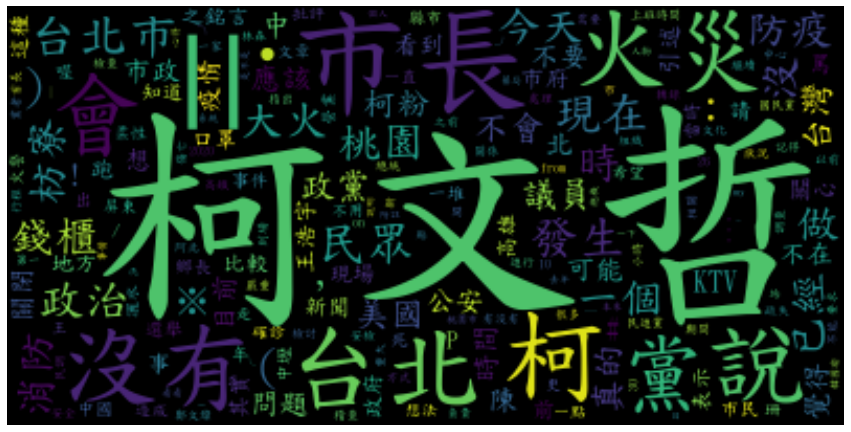

In [31]:
#產生WordCloud
wordcloud = WordCloud(font_path="kaiu.ttf")
wordcloud.generate_from_frequencies(frequencies=Counter(seg_list))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()